In [1]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/swiftai")' SwiftAI

Installing packages:
	.package(path: "/home/mlk/swift/swiftai")
		SwiftAI
With SwiftPM flags: []
Working in: /tmp/tmpab7kxayk/swift-install
[1/2] Compiling jupyterInstalledPackages jupyterInstalledPackages.swift
[2/3] Merging module jupyterInstalledPackages
Initializing Swift...
Installation complete!


In [2]:
import SwiftAI
import TensorFlow
import Python
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let plt = Python.import("matplotlib.pyplot")
let np = Python.import("numpy")
import Foundation
import Just
import Path

In [3]:
//extend string tensor to decode PNGs
public extension StringTensor { 
    func decodePng(channels: Int = 0) -> Tensor<UInt8> {
        return _Raw.decodePng(contents: self, channels: Int64(channels))
    }
}
//openPNG function
public func openPng(fname: StringTensor) -> TF{
    let decodedImg = StringTensor(readFile: fname).decodePng(channels: 3) 
    let img = Tensor<Float>(decodedImg) / 255.0
    return img
}
//downloaded at https://course.fast.ai/datasets
let il = ItemList(fromFolder: Path.home/"swift/cifar10", extensions: ["png"])
let sd = SplitData(il) {grandParentSplitter(fName: $0, valid: "test")}
var procLabel = CategoryProcessor()
let sld = makeLabeledData(sd, fromFunc: parentLabeler, procLabel: &procLabel)
let rawData = sld.toDataBunch(itemToTensor: pathsToTensor, labelToTensor: intsToTensor, bs: 128) 
let data = transformData(rawData) { openPng(fname: $0) }


In [4]:
data.train.ds.first(where: { _ in true })!.xb.shape

▿ [128, 32, 32, 3]
  ▿ dimensions : 4 elements
    - 0 : 128
    - 1 : 32
    - 2 : 32
    - 3 : 3


<Figure size 432x288 with 0 Axes>

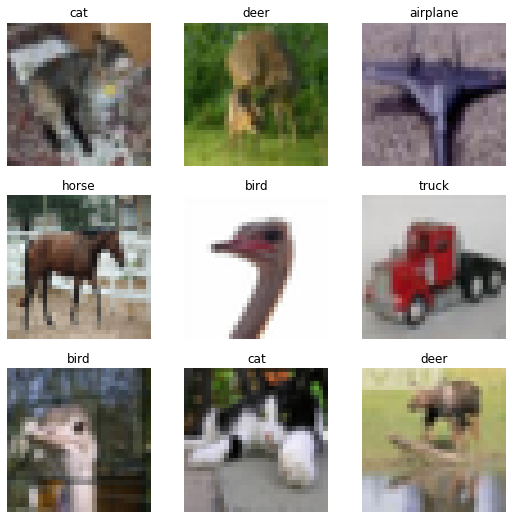

In [5]:
plt.figure()
let batch = data.train.oneBatch()!
let labels = batch.yb.scalars.map { procLabel.vocab![Int($0)] }
showImages(batch.xb, labels: labels)

In [6]:
public struct MyModel: Layer {
    public var Conv1:    ConvBN<Float>
    public var Conv2:    ConvBN<Float>
    public var Conv3:    ConvBN<Float>    
    public var Conv4:    ConvBN<Float>
    public var Conv5:    ConvBN<Float>
    public var Conv6:    ConvBN<Float>   
    public var Conv7:    ConvBN<Float>
    public var Conv8:    ConvBN<Float>
    public var pool =    MaxPool2D<Float>(poolSize: (2, 2), strides: (2,2))
    public var gpool =   GlobalMaxPool2D<Float>()
    public var flatten:  Flatten<Float>
    public var dropout = Dropout<Float>(probability: 0.1)
    public var fc1:      FADense<Float>
    public var out:      FADense<Float>

    public init(cIn: Int, nOut: Int, filterIn: [Int]){
        Conv1   = ConvBN(cIn        , filterIn[0], ks: 3, stride: 1, bn_mom: 0.05) //conv3-64
        Conv2   = ConvBN(filterIn[0], filterIn[0], ks: 3, stride: 1, bn_mom: 0.05) //conv64-64
        Conv3   = ConvBN(filterIn[0], filterIn[1], ks: 3, stride: 1, bn_mom: 0.05) //conv64-128
        Conv4   = ConvBN(filterIn[1], filterIn[1], ks: 3, stride: 1, bn_mom: 0.05) //conv128-128
        Conv5   = ConvBN(filterIn[1], filterIn[2], ks: 3, stride: 1, bn_mom: 0.05) //conv128-256
        Conv6   = ConvBN(filterIn[2], filterIn[2], ks: 3, stride: 1, bn_mom: 0.05) //conv256-256
        Conv7   = ConvBN(filterIn[2], filterIn[3], ks: 3, stride: 1, bn_mom: 0.05) //conv256-512
        Conv8   = ConvBN(filterIn[3], filterIn[3], ks: 3, stride: 1, bn_mom: 0.05) //conv512-512
        flatten = Flatten()
        fc1     = FADense(512,256)
        out     = FADense(256, nOut)
    }
    
    @differentiable
    public func callAsFunction(_ input: TF) -> TF {
        let x1 = input.compose(Conv1,Conv2,pool,dropout)
        let x2 = x1.compose(Conv3,Conv4,pool,dropout)
        let x3 = x2.compose(Conv5,Conv6,Conv6,pool,dropout)
        let x4 = x3.compose(Conv7,Conv8,Conv8,pool,dropout)
        let x5 = x4.compose(Conv8,Conv8,Conv8,gpool,dropout)
        let x6 = x5.compose(fc1,dropout,out)
        return x6
    }
}


In [7]:
func modelInit() -> MyModel { return MyModel(cIn: 3, nOut: 10, filterIn: [64,128,256,512]) }

In [8]:
let mean = Tensor<Float>([0.485, 0.456, 0.406])
let std = Tensor<Float>([0.229, 0.224, 0.225])
let optFunc: (MyModel) -> StatefulOptimizer<MyModel> = adamOpt(lr: 1e-3, mom: 0.9, beta: 0.99, wd: 2e-3, eps: 1e-6)
let learner = Learner(data: data, lossFunc: crossEntropy, optFunc: optFunc, modelInit: modelInit)
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.addDelegate(learner.makeNormalize(mean: mean, std: std))


In [9]:
learner.fit(10)

Epoch 0: [1.5641817, 0.462]                                                     
Epoch 1: [1.8636771, 0.5636]                                                    
Epoch 2: [0.836328, 0.7104]                                                     
Epoch 3: [0.68985325, 0.7674]                                                   
Epoch 4: [0.692282, 0.7755]                                                     
Epoch 5: [0.5831158, 0.8036]                                                    
Epoch 6: [0.5306884, 0.8285]                                                    
Epoch 7: [0.5663089, 0.8199]                                                    
Epoch 8: [0.6260632, 0.8016]                                                    
Epoch 9: [0.55856687, 0.8323]                                                   


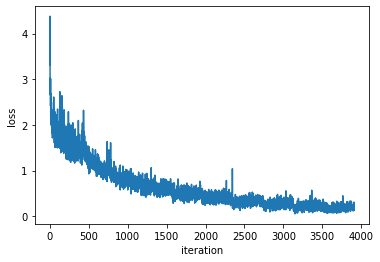

In [10]:
recorder.plotLosses()

In [11]:
learner.addOneCycleDelegates(1e-3, pctStart: 0.3)
learner.fit(3)

Epoch 0: [0.5584728, 0.8202]                                                    
Epoch 1: [0.5037533, 0.8397]                                                    
Epoch 2: [0.49426758, 0.8511]                                                   
